In [41]:
from preparing_script import agrofiz_plot, SVD_vis, suhoe_stats_barplot
import pandas as pd 
import numpy as np 
import scipy 
from scipy.stats import f_oneway as ANOVA
from itertools import cycle

import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Задачи 
- Бар плоты по фракциям сухого и мокрого просеивания 
- Лепестковые диаграмы  (https://python-graph-gallery.com/radar-chart/)
- Статистистика по всем объектам (с графикой и опсательными статистиками)

## Сухое просеивание 

In [6]:
suhoe = pd.read_csv('data/сухое просеивание все объекты.csv', index_col= 0)
size_cats = ['>10','10-7','7-5', '5-3', '3-2', '2-1', '1-0.5', '0.5-0.25', '<0.25']
suhoe['Размер агрегатов, мм'] = pd.CategoricalIndex(suhoe['Размер агрегатов, мм'], ordered=True, categories=size_cats)

In [7]:
test_df = suhoe[
    (suhoe["region"] == 'урожайное') & 
    (suhoe["Год"] == 2022) &
    suhoe['GPS №'].isin(['XX', 'XVIII'])
    ]

### Урожайное 2022 год точки XX/XVIII

Содержание агрегатов, %             
                                                      mean    std   sem
Тип обработки Размер агрегатов, мм                                     
ПП            >10                                    57.36  10.56  4.72
              10-7                                    7.13   1.82  0.81
              7-5                                     7.00   1.73  0.77
              5-3                                     9.53   2.73  1.22
              3-2                                     6.37   1.74  0.78
              2-1                                     9.03   2.60  1.16
              1-0.5                                   0.72   0.13  0.06
              0.5-0.25                                1.56   0.25  0.11
              <0.25                                   1.32   0.28  0.12
ТТ            >10                                    62.45  16.71  7.47
              10-7                                    5.95   3.39  1.51
              7-5                                     5.52   2.86  1.28
              5-3                                     7.48   3.71  1.66
              3-2                                     5.10   2.55  1.14
              2-1                                     8.08   4.37  1.95
              1-0.5                                   1.93   2.49  1.11
              0.5-0.25                                1.83   0.87  0.39
              <0.25                                   1.67   0.86  0.39

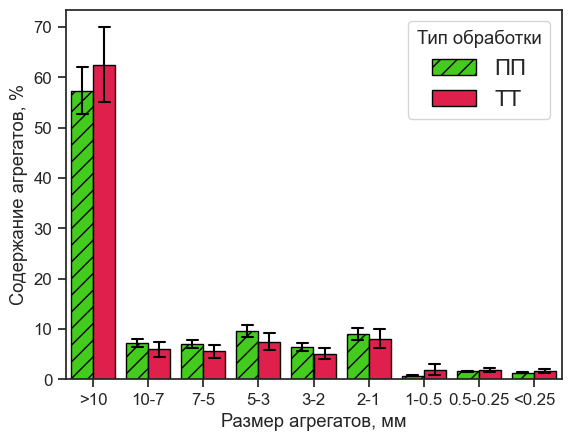

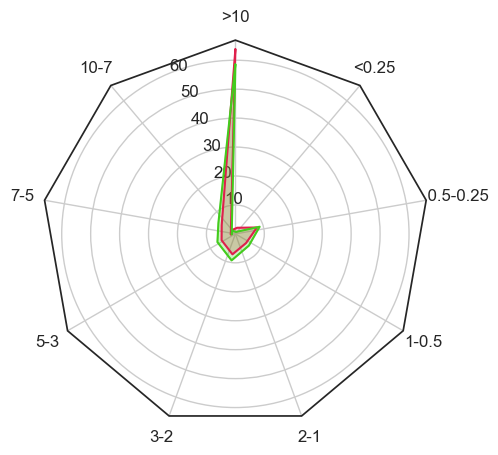

In [53]:
suhoe_uroshaynoe_2022 = suhoe[
    (suhoe["region"] == 'урожайное') & 
    (suhoe["Год"] == 2022) &
    suhoe['GPS №'].isin(['XX', 'XVIII'])
    ]


plot,rp_plot, stats = suhoe_stats_barplot(suhoe_uroshaynoe_2022)
stats

### Урожайное 2017 год точки XX/XVIII

Содержание агрегатов, %             
                                                      mean    std   sem
Тип обработки Размер агрегатов, мм                                     
ПП            >10                                    67.78  11.69  5.23
              10-7                                    7.30   3.37  1.51
              7-5                                     5.16   1.84  0.82
              5-3                                     6.46   2.27  1.02
              3-2                                     4.13   1.72  0.77
              2-1                                     5.49   2.52  1.12
              1-0.5                                   0.52   0.16  0.07
              0.5-0.25                                1.35   0.55  0.25
              <0.25                                   1.81   0.80  0.36
ТТ            >10                                    53.92  12.12  5.42
              10-7                                    9.64   4.74  2.12
              7-5                                     7.71   2.44  1.09
              5-3                                     9.24   2.57  1.15
              3-2                                     5.74   1.29  0.58
              2-1                                     8.63   1.44  0.65
              1-0.5                                   0.60   0.11  0.05
              0.5-0.25                                1.94   0.34  0.15
              <0.25                                   2.59   0.39  0.17

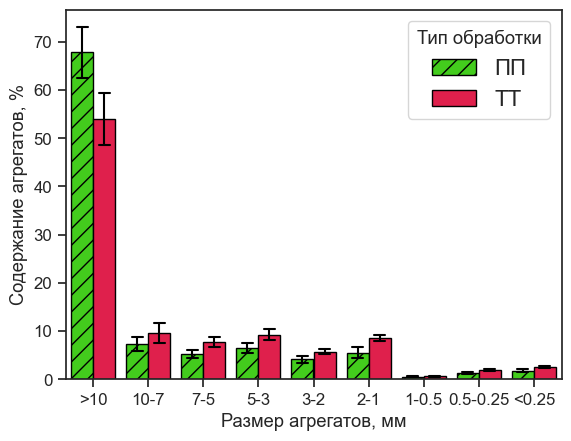

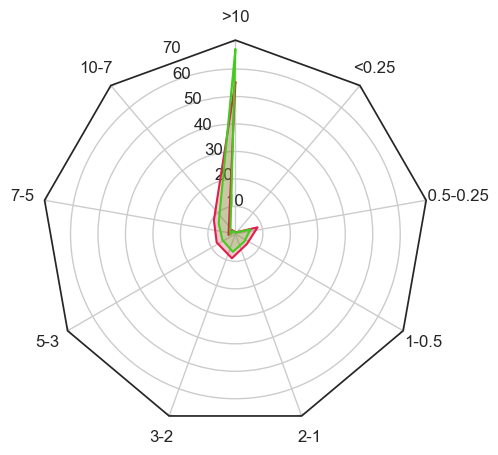

In [54]:
suhoe_uroshaynoe_2017 = suhoe[
    (suhoe["region"] == 'урожайное') & 
    (suhoe["Год"] == 2017) &
    suhoe['GPS №'].isin(['XX', 'XVIII'])
    ]


plot,rp_plot, stats = suhoe_stats_barplot(suhoe_uroshaynoe_2017)
stats

### Курск 2019

Содержание агрегатов, %             
                                                      mean    std   sem
Тип обработки Размер агрегатов, мм                                     
ПП            >10                                    56.49   6.83  3.05
              10-7                                    6.12   1.27  0.57
              7-5                                     5.79   1.59  0.71
              5-3                                     7.53   1.29  0.58
              3-2                                     5.90   1.52  0.68
              2-1                                    14.82   1.64  0.73
              1-0.5                                   0.62   0.28  0.12
              0.5-0.25                                1.64   0.85  0.38
              <0.25                                   1.10   0.83  0.37
ТТ            >10                                    55.54  15.19  6.79
              10-7                                    5.06   1.49  0.67
              7-5                                     4.78   1.41  0.63
              5-3                                     7.21   2.30  1.03
              3-2                                     6.49   3.28  1.47
              2-1                                    17.59   6.25  2.79
              1-0.5                                   0.60   0.23  0.10
              0.5-0.25                                1.62   0.74  0.33
              <0.25                                   1.13   0.47  0.21

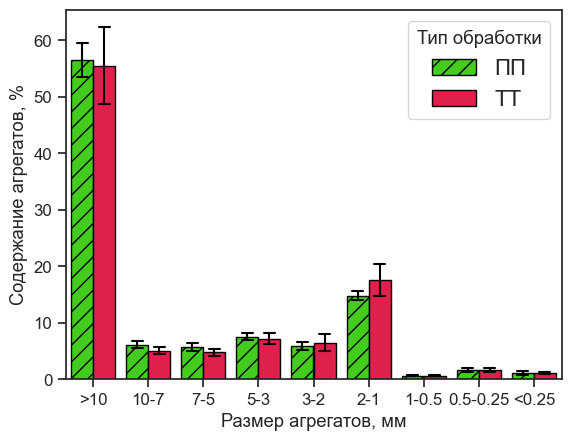

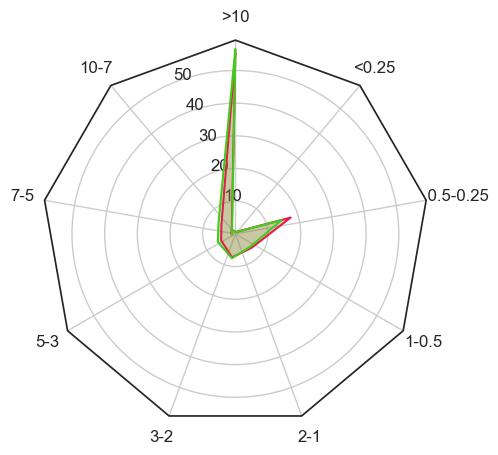

In [57]:
suhoe_kursk_2019 = suhoe[
    (suhoe["region"] == 'Курск')  
    ]


plot,rp_plot, stats = suhoe_stats_barplot(suhoe_kursk_2019)
stats

### Архангельский 2019

Содержание агрегатов, %             
                                                      mean    std   sem
Тип обработки Размер агрегатов, мм                                     
ПП            >10                                    57.34   4.03  1.80
              10-7                                    7.53   0.92  0.41
              7-5                                     7.00   0.47  0.21
              5-3                                     8.10   0.93  0.42
              3-2                                     5.53   0.45  0.20
              2-1                                     7.45   2.21  0.99
              1-0.5                                   1.23   0.89  0.40
              0.5-0.25                                2.45   0.24  0.11
              <0.25                                   3.36   1.18  0.53
ТТ            >10                                    43.11  10.20  4.56
              10-7                                    6.98   3.62  1.62
              7-5                                     5.91   3.19  1.43
              5-3                                     7.71   4.10  1.84
              3-2                                     6.10   3.28  1.47
              2-1                                    11.88   5.41  2.42
              1-0.5                                   8.42   4.29  1.92
              0.5-0.25                                4.40   3.18  1.42
              <0.25                                   5.50   3.57  1.59

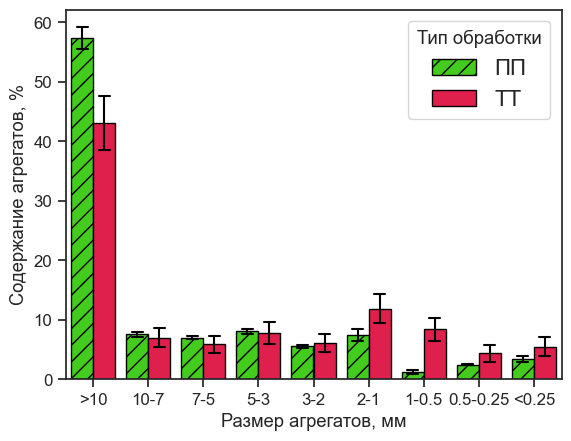

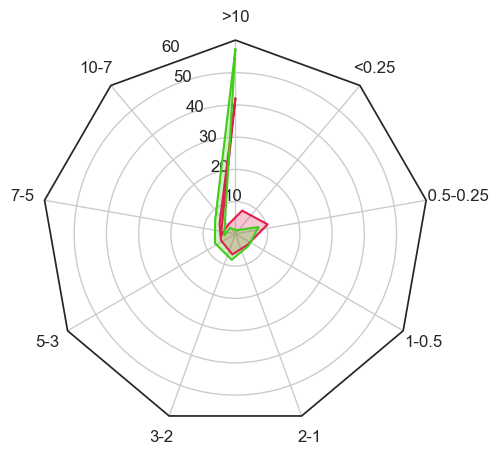

In [65]:
suhoe_archan_2019 = suhoe[
    (suhoe["region"] == 'архангельский')  
    ]

suhoe_archan_2019.sort_values(by = 'Тип обработки', inplace= True)
plot,rp_plot, stats = suhoe_stats_barplot(suhoe_archan_2019)
stats